# Auto Sampler script
## Elveflow Instruments
* OB1 pressure controller
* MUX Wire
* 

## Import Libraries

In [97]:
%reset -f

# Import Elveflow library
import sys
import os
from email.header import UTF8
# SDK_HOME = 'C:/Users/Admin/ELVEFLOW/SDK_V3_04_04'
SDK_HOME = 'C:/Users/Admin/ELVEFLOW/ESI_V3_04_01/SDK V3_04_01'
sys.path.append(SDK_HOME+'/DLL64/DLL64')#add the path of the library here
sys.path.append(SDK_HOME+'/Python_64')#add the path of the LoadElveflow.py

from ctypes import *

from array import array

from Elveflow64 import *

## Instrument Class definitions

In [98]:
Z_regulator_type = {
    'none': 0,
    '0_200_mbar': 1,
    '0_2000_mbar': 2,    
    '0_8000_mbar': 3,
    'm1000_1000_mbar': 4,
    'm1000_6000_mbar': 5
}
Z_sensor_type = {
    'none': 0,
    'Flow_1_5_uL_min': 1,
    'Flow_7_uL_min': 2,
    'Flow_50_uL_min': 3,
    'Flow_80_uL_min': 4,
    'Flow_1000_uL_min': 5,
    'Flow_5000_uL_min': 6,
    'Press_340_mbar': 7,
    'Press_1_bar': 8,
    'Press_2_bar': 9,
    'Press_7_bar': 10,
    'Press_16_bar': 11,
    'Level': 12
}

def _check_error(task, error):
    err_dict = {
        -8000: 'No Digital Sensor found',
        -8001: 'No pressure sensor compatible with OB1 MK3',
        -8002: 'No Digital pressure sensor compatible with OB1 MK3+',
        -8003: 'No Digital Flow sensor compatible with OB1 MK3',
        -8004: 'No IPA config for this sensor',
        -8005: 'Sensor not compatible with AF1',
        -8006: 'No Instrument with selected ID'
    }
    if error != 0:
        if error in err_dict:
            raise RuntimeError('{} failed with error code {}\n{}'.format(task, error, err_dict[error]))
        else:
            raise RuntimeError('{} failed with error code {}\n{}'.format(task, error, 'Unknown error, see http://www.ni.com/pdf/manuals/321551a.pdf'))
            
class ob1():
    def __init__(self, address='01EF64C3', calibrate=False):
        self.Instr_ID = c_int32()
        print('Instrument name and regulator types hardcoded in the python script'.encode('utf-8'))
        # see User guide to determine regulator type NI MAX to determine the instrument name
        # channel 1: -1000~1000 mBar, channel 2: none, channel 3: none, channel 4:none
        error = OB1_Initialization(address.encode('ascii'), 
                                   Z_regulator_type['m1000_1000_mbar'], 
                                   Z_regulator_type['none'], 
                                   Z_regulator_type['none'], 
                                   Z_regulator_type['none'], 
                                   byref(self.Instr_ID))
        # all functions will return error code to help you to debug your code, for further information see user guide
        _check_error('OB1 Initialization', error)

        # add one digital flow sensor to OB1 channel 1, 1mL/min, digital, water calibration, 16bit resolution, 
#         error=OB1_Add_Sens(self.Instr_ID, 1, Z_sensor_type['Flow_1000_uL_min'], 1, 0, 7, 0)
        # add one digital flow sensor to OB1 channel 1, 5mL/min, digital, water calibration, 16bit resolution, 
        error=OB1_Add_Sens(self.Instr_ID, 1, Z_sensor_type['Flow_5000_uL_min'], 1, 0, 7, 0)
        _check_error('Adding digital flow sensor', error)

        self.calib_path = os.path.abspath('ob1_calibration.txt')
        print(self.calib_path)
        self.Calib = (c_double * 1000)()
        if calibrate:
            print ('Starting calibration')
            OB1_Calib(self.Instr_ID.value, self.Calib, 1000)
            error = Elveflow_Calibration_Save(self.calib_path.encode('ascii'), byref(self.Calib), 1000)
            print ('Calibration finished')
            print ('Calibration saved in file %s' % self.calib_path.encode('ascii'))
        else:
            if not os.path.isfile(self.calib_path):
                raise IOError('Calibration file "{}" does not exist'.format(self.calib_path))               
            error = Elveflow_Calibration_Load(self.calib_path.encode('ascii'), byref(self.Calib), 1000)
            _check_error('Loading calibration file', error)            
            
        self.set_pressure(0)

    def meas_flowrate(self, channel=1):
        """
        Measures the instantaneous flow rate, on designated port.
        Parameters:
            channel: ob1 channel to set (1-4), defaults to 1
        return: (flowrate, error code)
            flowrate in uL/min
            0 : successful
            -1 : parameter error
            otherwise: NI error
        """
        if channel <1 or channel > 4:
            print('ob1.meas_flowrate: channel must be within 1~4')
            return -1
        
        set_channel = c_int32(channel)  # convert to c_int32
        get_flowrate = c_double(0.0)
        error = OB1_Get_Sens_Data(self.Instr_ID.value, set_channel, Acquire_Data1True0False=1, Sens_Data=byref(get_flowrate))  # Acquire_data =1 -> Read all the analog value
#         print('Press or Flow ch', set_channel.value,': ',get_flowrate.value)
#         _check_error('Getting data from flow sensor', error)
        
        return get_flowrate.value, error

    def set_pressure(self, pressure, channel=1):
        """
        Sets the pressure, on designated port.
        Parameters:
            pressure: target pressure in mBar (-1000 to 8000)
            channel: ob1 channel to set (1-4), defaults to 1
        return: error code
            0 : successful
            -1 : parameter error
            otherwise: NI error
        """      
        
        # check parameters
        if pressure >8000.0 or pressure < -1000.0:
            print('ob1.set_pressure: Error pressure must be within -1000~8000')
            return -1
        if channel <1 or channel > 4:
            print('set_pressure: channel must be within 1~4')
            return -1
        
        set_channel=c_int32(channel)#convert to c_int32        
        set_pressure=c_double(pressure) #convert to c_double        
        error=OB1_Set_Press(self.Instr_ID.value, set_channel, set_pressure, byref(self.Calib),1000) 
        _check_error('Setting pressure', error)
        
        return error
    
    def meas_pressure(self, channel=1):
        """
        Measures the instantaneous pressure, on designated channel.
        Parameters:
            channel: ob1 channel to set (1-4), defaults to 1
        return: (pressure, error code)
            flowrate in mBar
            0 : successful
            -1 : parameter error
            otherwise: NI error
        """
        if channel <1 or channel > 4:
            print('ob1.meas_pressure: channel must be within 1~4')
            return -1
        
        set_channel = c_int32(channel)  # convert to c_int32
        get_pressure = c_double(0.0)
        error = OB1_Get_Press(self.Instr_ID.value, set_channel, Acquire_Data1True0False=1, Calib_array_in=self.Calib, Pressure=byref(get_pressure), Calib_Array_len=1000)  # Acquire_data =1 -> Read all the analog value
        print('Press ch 1: ',get_pressure.value)
#         _check_error('Getting pressure from OB1', error)
        
        return get_pressure.value, error
    
    def __del__(self):
        self.set_pressure(0)
        error=OB1_Destructor(self.Instr_ID.value)
        
class mux_wire():
    def __init__(self, address='Dev2'):
        self.Instr_ID = c_int32()
        # see User guide to determine regulator type NI MAX to determine the instrument name
        error = MUX_Initialization(address.encode('ascii'), byref(self.Instr_ID))
        # all functions will return error code to help you to debug your code, for further information see user guide
        _check_error('MUX Initialization', error)
        print(error)
        
        self.state = [0]*8
        
    def set_all_valves(self, state):
        """
        Sets state of all valves
        Parameters:
            state: 8 integer (0: close, 1: open)
        return: error code
            0 : successful
            -1 : parameter error
            otherwise: NI error
        """
        if not (isinstance(state, list) and len(state) == 8):
            print('Error mux_wire.set_all_valves: state has to be a list of 8 integers')
            return -1
        
        self.state = state
        valve_state=(c_int32*16)(0)
        for i in range(8):
            valve_state[i]=c_int32(state[i]) 
            
        error=MUX_Wire_Set_all_valves(self.Instr_ID.value, valve_state, 16)
        
        return error     
    
    def set_valve(self, channel, state):
        """
        Sets state of a certain valve
        Parameters:
            channel: integer (1-8)
            state: integer (0: close to N.O., 1: open to N.C.)
        return: error code
            0 : successful
            -1 : parameter error
            otherwise: NI error
        """
        if not isinstance(state, int):
            print('Error mux_wire.set_valve: state has to be an integer')
            return -1
        if not (isinstance(channel, int) and channel>0 and channel<9) :
            print('Error mux_wire.set_valve: channel has to be integer (1-8)')
            return -1
                
        self.state[channel-1] = state
        valve_state=(c_int32*16)(0)
        for i in range(8):
            valve_state[i]=c_int32(self.state[i]) 
            
        error=MUX_Wire_Set_all_valves(self.Instr_ID.value, valve_state, 16)
        
    def get_state(self):
        """
        Returns state of current valves: list of 8 integers
        """
        return self.state
            
    def __del__(self):
        error=MUX_Destructor(self.Instr_ID.value)
        
class msr():
    def __init__(self, address='01EE3A2D'):
        self.Instr_ID = c_int32()
        # see User guide to determine regulator type NI MAX to determine theerror=M_S_R_D_Initialization('01DAA568'.encode('ascii'),5,0,0,0,0,0,byref(Instr_ID)) 
        
        error = M_S_R_D_Initialization(address.encode('ascii'),
                                       Sens_Ch_1=Z_sensor_type['Flow_5000_uL_min'],
                                       Sens_Ch_2=Z_sensor_type['none'],
                                       Sens_Ch_3=Z_sensor_type['Flow_1000_uL_min'],
                                       Sens_Ch_4=Z_sensor_type['none'],
                                       CustomSens_Voltage_Ch12=5,  # 5-25V unused for digital sensors
                                       CustomSens_Voltage_Ch34=5,  # 5-25V unused for digital sensors
                                       MSRD_ID_out=byref(self.Instr_ID))
        # all functions will return error code to help you to debug your code, for further information see user guide
        _check_error('MSR Initialization', error)
        print(error)
        
        # Add sensors
        #   on channel 1
        error =  M_S_R_D_Add_Sens(self.Instr_ID.value, 
                                  Channel_1_to_4         = c_int32(1),
                                  SensorType             = Z_sensor_type['Flow_5000_uL_min'],
                                  DigitalAnalog          = c_uint16(1), # Digital
                                  FSens_Digit_Calib      = c_uint16(0), # water calibration
                                  FSens_Digit_Resolution = c_uint16(0)) # 16 bit
        
        print('error add digital flow sensor on channel 1:%d' % error)
        
        #   on channel 3
        error =  M_S_R_D_Add_Sens(self.Instr_ID.value, 
                                  Channel_1_to_4         = c_int32(3),
                                  SensorType             = Z_sensor_type['Flow_1000_uL_min'],
                                  DigitalAnalog          = c_uint16(1), # Digital
                                  FSens_Digit_Calib      = c_uint16(0), # water calibration
                                  FSens_Digit_Resolution = c_uint16(0)) # 16 bit
        
        print('error add digital flow sensor on channel 3:%d' % error)
        
        
    def meas_flowrate(self, channel=1):
        """
        Measures the instantaneous flow rate, on designated port.
        Parameters:
            channel: MSR channel to set (1-4), defaults to 1
        return: (flowrate, error code)
            flowrate in uL/min
            0 : successful
            -1 : parameter error
            otherwise: NI error
        """
        if channel <1 or channel > 4:
            print('msr.meas_flowrate: channel must be within 1~4')
            return -1
        
        set_channel = c_int32(channel)  # convert to c_int32
        get_flowrate = c_double(0.0)
        error = M_S_R_D_Get_Sens_Data(Channel_1_to_4=set_channel,
                                      M_S_R_D_ID=self.Instr_ID.value, 
                                      Sens_Data=byref(get_flowrate))
        
        return get_flowrate.value, error
    
    def __del__(self):
        error=M_S_R_D_Destructor(self.Instr_ID.value)
        
class sampler():
    def __init__(self):
        """
        Initialization
        """
        self.ob1 = ob1(calibrate=False)
        self.mux_wire = mux_wire()
        
    def set_valves(self, reservoir, target):
        """
        Sets valve configuration of sampling system
        """
        state = self.mux_wire.get_state()
        if reservoir=='air':
#             print('sampler.set_valves: Set air reservoir')
            state[1] = 0
        elif reservoir == 'water':
            state[1] = 1
            
        if target=='waste':
            state[0] = 0
        elif target == 'tflask':
            state[0] = 1
            
        error = self.mux_wire.set_all_valves(state)
        
        return error
    
    def pushpull(self, mode, target, pressure = -10):
        """
        Push or pulls a certain volume or for some time using OB1 and connected flow sensor        
        Parameters:
            mode: integer (0: time mode, 1: volume mode)
            target: float (in seconds and uL)
            pressure: float (pressure in mbar)
        return: timestamp, volume
        """
        from time import time, sleep
        timeout = 30 # seconds
        time_step = 0.5
        
        if mode >1 or mode <0:
            print('Error sampler.pull: mode has to be integer 0 or 1')
            return -1
        if target < 0 :
            print('Error sampler.pull: target has to be a positive float')
            return -1
        vol_data = []
        time_data = []
        cur_vol = 0.0
        
        
        self.ob1.set_pressure(pressure)
        start_time = time()
        cur_time = time()
        if mode == 0: # timer mode            
            while cur_time-start_time < target:                
                flowrate,error = self.ob1.meas_flowrate()
                
                next_time = time()
                cur_vol = cur_vol + flowrate/60*(next_time-cur_time)
                cur_time = time()
                
                vol_data.append(cur_vol)
                time_data.append(cur_time)
                print('{} uL/min, cumulative {} uL at {} sec'.format(flowrate, cur_vol, cur_time-start_time))
                
                sleep(time_step)
                
        elif mode == 1:   # volume mode
            if pressure <0:
                pol = -1.0
            else:
                pol = 1.0
            while cur_time-start_time < timeout and pol*cur_vol < target:
                flowrate,error = self.ob1.meas_flowrate()
                
                next_time = time()
                cur_vol = cur_vol + flowrate/60*(next_time-cur_time)
                cur_time = time()
                
                vol_data.append(cur_vol)
                time_data.append(cur_time)
                print('{} uL/min, cumulative {} uL at {} sec'.format(flowrate, cur_vol, cur_time-start_time))
                
                sleep(time_step)
                
        self.ob1.set_pressure(0)
        
        return time_data, vol_data
    
    def __del__(self):
        
        self.set_valves('air', 'waste')
        self.ob1.set_pressure(0)
        

In [99]:
poe = sampler()

poe.set_valves('air', 'waste')
poe.ob1.set_pressure(0)


b'Instrument name and regulator types hardcoded in the python script'
C:\Users\Admin\Documents\GitHub\fluid-auto-sampler\control_scripts\ob1_calibration.txt
0


0

In [96]:
del poe

In [38]:
sens = msr()

0
error add digital flow sensor on channel 1:0
error add digital flow sensor on channel 3:0


In [56]:
sens.meas_flowrate(channel=3)

(-4.310344827586207, 0)

In [57]:
del sens

In [94]:
poe.set_valves('air', 'waste')

0

In [107]:
poe.set_valves('air', 'tflask')

0

In [108]:
poe.ob1.set_pressure(200)

0

In [7]:
poe.ob1.set_pressure(5)

0

In [113]:
poe.ob1.set_pressure(0)

0

In [123]:
poe.ob1.meas_flowrate()

(6.0, 0)

In [50]:
poe.ob1.meas_pressure()

Press ch 1:  3.9587616007997894


(3.9587616007997894, 0)

Time 0.013001: err=  194 err_i= 29.1 y=    6 x=60.787
Time 0.17001: err=189.2 err_i=57.48 y= 10.8 x=58.636
Time 0.33002: err=169.4 err_i=82.89 y= 30.6 x=58.268
Time 0.48803: err=169.4 err_i=108.3 y= 30.6 x=64.01
Time 0.64904: err=149.4 err_i=130.71 y= 50.6 x=62.825
Time 0.80905: err=144.4 err_i=152.37 y= 55.6 x=66.407
Time 0.96606: err=  139 err_i=173.22 y=   61 x=69.214
Time 1.1261: err=102.4 err_i=188.58 y= 97.6 x=62.096
Time 1.2861: err=107.8 err_i=204.75 y= 92.2 x=68.08
Time 1.4461: err= 78.6 err_i=216.54 y=121.4 x=61.985
Time 1.6041: err= 79.2 err_i=228.42 y=120.8 x=65.504
Time 1.7641: err= 73.6 err_i=239.46 y=126.4 x=66.105
Time 1.9241: err= 48.2 err_i=246.69 y=151.8 x=60.541
Time 2.0841: err= 48.4 err_i=253.95 y=151.6 x=62.897
Time 2.2441: err= 34.8 err_i=259.17 y=165.2 x=60.081
Time 2.4021: err= 34.8 err_i=264.39 y=165.2 x=61.578
Time 2.5621: err= 34.2 err_i=269.52 y=165.8 x=62.434
Time 2.7222: err= 16.2 err_i=271.95 y=183.8 x=57.84
Time 2.8822: err= 12.4 err_i=273.81 y=187.6 x

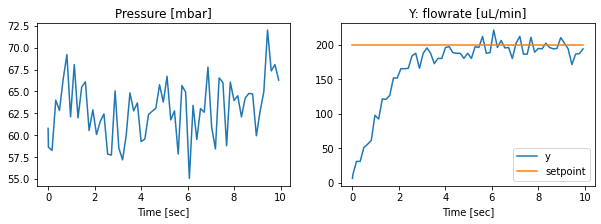

In [125]:
from time import sleep, time
import matplotlib.pyplot as plt

poe.set_valves('water', 'tflask')

# PID attempt

Kp = 0.25
Ki = 0.2
Kd = 0.005

setpoint = 200.0 # uL/min

timeout = 10.0 # sec
start_time = time()
cur_time = time()-start_time
err_i = 0.0
err_d = 0.0
err_prev = 0.0
dt = 0.15 # sec

# traces
t_arr = []
x_arr = []
y_arr = []
while cur_time < timeout:
    y,flag = poe.ob1.meas_flowrate()
    if flag == 0:
        err = setpoint - y

        err_i = err_i + err*dt
        err_d = (err - err_prev)/dt

        x = Kp*err + Ki*err_i + Kd*err_d
        
        if x > 1000:
            print('Pressure over range {}'.format(x))
            x = 1000.0
        elif x < -900:
            print('Pressure under range {}'.format(x))
            x = -900.0
            
        poe.ob1.set_pressure(x)
        
        x_arr.append(x)
        y_arr.append(y)
        t_arr.append(cur_time)
        

        err_prev = err
        cur_time = time()-start_time
        print('Time {:5.5g}: err={:5.5g} err_i={:5.5g} y={:5.5g} x={:5.5g}'.format(cur_time, err, err_i, y, x))
    else:
        print('Flow rate sensor error {}, value {}'.format(flag, y))
        
    sleep(dt)

poe.set_valves('air', 'tflask')
poe.ob1.set_pressure(200.0)
sleep(5.0)
poe.ob1.set_pressure(0.0)


# plot results
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.title('Pressure [mbar]')
plt.plot(t_arr, x_arr, label='x')
plt.xlabel('Time [sec]')


plt.subplot(122)
plt.title('Y: flowrate [uL/min]')
plt.plot(t_arr, y_arr, label='y')
plt.plot([t_arr[0],t_arr[-1]], [setpoint, setpoint], label='setpoint')
plt.xlabel('Time [sec]')
plt.legend()
plt.savefig('PID.png', dpi=200)
plt.show()

In [115]:
print('{:4.3g}'.format(1.1122))

1.11


sampler.set_valves: Set air reservoir
-4.344827586206897 uL/min, cumulative -0.00043448579722437367 uL at 0.006000041961669922 sec
-4.344827586206897 uL/min, cumulative -0.03722280880500531 uL at 0.5140292644500732 sec
-5.413793103448276 uL/min, cumulative -0.08306220564348944 uL at 1.0220582485198975 sec
-5.413793103448276 uL/min, cumulative -0.12890162399445457 uL at 1.5300874710083008 sec
-4.344827586206897 uL/min, cumulative -0.16568992973744184 uL at 2.038116455078125 sec
-4.344827586206897 uL/min, cumulative -0.20247825274522277 uL at 2.5461456775665283 sec
-4.344827586206897 uL/min, cumulative -0.23926655848821005 uL at 3.0541746616363525 sec
-4.344827586206897 uL/min, cumulative -0.2760548642311973 uL at 3.5622036457061768 sec
-4.344827586206897 uL/min, cumulative -0.31284318723897825 uL at 4.07023286819458 sec
-4.344827586206897 uL/min, cumulative -0.3496314929819655 uL at 4.578261852264404 sec
-4.344827586206897 uL/min, cumulative -0.38634737291555293 uL at 5.0852906703948975

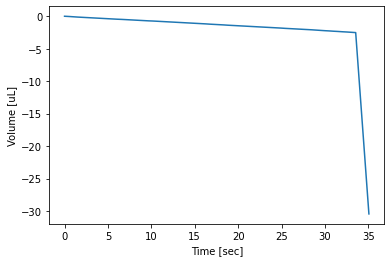

In [140]:
import matplotlib.pyplot as plt
poe.set_valves('air', 'tflask')
time,vol = poe.pushpull(mode=1, target=30, pressure=-20)
poe.set_valves('air', 'waste')
time_rel = [t-time[0] for t in time]
plt.plot(time_rel, vol)
plt.xlabel('Time [sec]')
plt.ylabel('Volume [uL]')
plt.show()

In [70]:
del poe

In [4]:
# kenobi=ob1(calibrate=True)
kenobi=ob1(calibrate=False)

b'Instrument name and regulator types hardcoded in the python script'
C:\Users\Admin\Documents\GitHub\fluid-auto-sampler\control_scripts\ob1_calibration.txt


In [54]:
p,e = kenobi.meas_pressure()

print(p)

99.91674880079995


In [26]:
kenobi.set_pressure(-50)

NameError: name 'kenobi' is not defined

In [11]:
kenobi.meas_flowrate()

(-6.551724137931035, 0)

In [45]:
mux = mux_wire()

0


In [57]:
state = [1, 0, 0, 0, 0, 0, 0, 0]
mux.set_all_valves(state)

0

In [38]:
isinstance(state, list)

True

In [7]:
print(os.path.expanduser(r'./ob1_calibration.txt'))
print(os.getcwd())
print(os.path.relpath('ob1_calibration.txt'))
print(os.path.abspath('ob1_calibration.txt'))

./ob1_calibration.txt
C:\Users\Admin\Documents\GitHub\fluid-auto-sampler\control_scripts
ob1_calibration.txt
C:\Users\Admin\Documents\GitHub\fluid-auto-sampler\control_scripts\ob1_calibration.txt


In [12]:
del kenobi
del mux

NameError: name 'mux' is not defined

In [13]:
print([0]*8)

[0, 0, 0, 0, 0, 0, 0, 0]
